In [1]:
"""
=============================================================================
UYGULAMA 4: İleri Düzey Random Forest + Ensemble Karşılaştırması
=============================================================================
Kapsam:
  - RandomForestClassifier hiperparametre optimizasyonu
  - GridSearchCV vs RandomizedSearchCV karşılaştırması
  - StratifiedKFold cross-validation (data leakage'sız)
  - XGBoost, GradientBoosting ile kapsamlı karşılaştırma
  - Öğrenme eğrisi (Learning Curve) analizi
  - Confusion Matrix & ROC-AUC görselleştirmesi
  - Feature Importance (RF built-in)

Veri: UCI Bank Marketing (Uygulama 1'den devam)
Gereksinimler: pip install scikit-learn xgboost pandas numpy matplotlib seaborn
=============================================================================
"""


"\n=============================================================================\nUYGULAMA 2: İleri Düzey Random Forest + Ensemble Karşılaştırması\n=============================================================================\nKapsam:\n  - RandomForestClassifier hiperparametre optimizasyonu\n  - GridSearchCV vs RandomizedSearchCV karşılaştırması\n  - StratifiedKFold cross-validation (data leakage'sız)\n  - XGBoost, GradientBoosting ile kapsamlı karşılaştırma\n  - Öğrenme eğrisi (Learning Curve) analizi\n  - Confusion Matrix & ROC-AUC görselleştirmesi\n  - Feature Importance (RF built-in)\n\nVeri: UCI Bank Marketing (Uygulama 1'den devam)\nGereksinimler: pip install scikit-learn xgboost pandas numpy matplotlib seaborn\n=============================================================================\n"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    learning_curve,
)
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    ConfusionMatrixDisplay,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.base import BaseEstimator, TransformerMixin
import time
import warnings
warnings.filterwarnings("ignore")


In [4]:
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost kurulu değil. pip install xgboost")


In [5]:
# ─────────────────────────────────────────────────────────────
# 1. VERİ HAZIRLAMA (Uygulama 1'den bağımsız çalışır)
# ─────────────────────────────────────────────────────────────
print("=" * 65)
print(" UYGULAMA 2: İleri Düzey RF + Ensemble Karşılaştırması")
print("=" * 65)

np.random.seed(42)
n = 8000
df = pd.DataFrame({
    "age":       np.random.randint(18, 75, n).astype(float),
    "balance":   np.random.normal(1500, 3000, n),
    "duration":  np.abs(np.random.normal(260, 260, n)),
    "campaign":  np.random.randint(1, 10, n).astype(float),
    "pdays":     np.random.choice([999] + list(range(0, 30)), n,
                                  p=[0.85] + [0.005] * 30).astype(float),
    "previous":  np.random.randint(0, 5, n).astype(float),
    "job":       np.random.choice(["admin.", "blue-collar", "technician",
                                   "services", "management"], n),
    "marital":   np.random.choice(["married", "single", "divorced"], n),
    "education": np.random.choice(["basic.4y", "high.school",
                                   "university.degree", "professional.course"], n),
    "contact":   np.random.choice(["telephone", "cellular"], n),
    "poutcome":  np.random.choice(["failure", "success", "nonexistent"], n),
})

# Gerçekçi target (duration ile pozitif korelasyon)
prob = 0.05 + 0.15 * (df["duration"] > 300) + 0.12 * (df["previous"] > 0)
df["target"] = (np.random.rand(n) < prob.clip(0, 1)).astype(int)

# Eksik değer ekle
for col in ["age", "balance"]:
    df.loc[np.random.rand(n) < 0.05, col] = np.nan
for col in ["job", "education"]:
    df.loc[np.random.rand(n) < 0.08, col] = np.nan

num_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
cat_ohe = ["job", "marital", "contact", "poutcome"]
cat_ord = ["education"]
all_features = num_cols + cat_ohe + cat_ord

X = df[all_features]
y = df["target"]
print(f"\n📊 Veri: {X.shape[0]:,} örnek, {X.shape[1]} feature")
print(f"   Hedef dağılımı: {y.value_counts().to_dict()} → dengesiz veri!")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


 UYGULAMA 2: İleri Düzey RF + Ensemble Karşılaştırması

📊 Veri: 8,000 örnek, 11 feature
   Hedef dağılımı: {0: 6246, 1: 1754} → dengesiz veri!


In [6]:
# ─────────────────────────────────────────────────────────────
# 2. ORTAK PREPROCESSOR (Uygulama 1'den alındı)
# ─────────────────────────────────────────────────────────────
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower; self.upper = upper
    def fit(self, X, y=None):
        self.l_ = np.nanquantile(X, self.lower, axis=0)
        self.u_ = np.nanquantile(X, self.upper, axis=0)
        return self
    def transform(self, X):
        return np.clip(np.array(X, dtype=float), self.l_, self.u_)

num_pipe = Pipeline([
    ("imputer", IterativeImputer(max_iter=10, random_state=42)),
    ("clipper", OutlierClipper()),
    ("scaler",  RobustScaler()),
])
cat_ohe_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])
cat_ord_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
])
preprocessor = ColumnTransformer([
    ("num",     num_pipe,     num_cols),
    ("cat_ohe", cat_ohe_pipe, cat_ohe),
    ("cat_ord", cat_ord_pipe, cat_ord),
], remainder="drop")


In [7]:
# ─────────────────────────────────────────────────────────────
# 3. GRIDSEARCHCV ile RF OPTİMİZASYONU
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("⚙️  GridSearchCV ile RF Hiperparametre Optimizasyonu")
print("─" * 50)

rf_param_grid = {
    "classifier__n_estimators":     [100, 200],
    "classifier__max_depth":        [10, 20, None],
    "classifier__min_samples_leaf": [2, 4, 8],
    "classifier__max_features":     ["sqrt", "log2"],
    "classifier__class_weight":     ["balanced"],
}

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1)),
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("⏳ GridSearchCV çalışıyor (küçük grid)...")
t0 = time.time()
grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0,
    return_train_score=True,
)
grid_search.fit(X_train, y_train)
t1 = time.time()

print(f"✅ Tamamlandı ({t1-t0:.1f}s) | En iyi CV AUC: {grid_search.best_score_:.4f}")
print(f"   En iyi parametreler: {grid_search.best_params_}")

best_rf = grid_search.best_estimator_




──────────────────────────────────────────────────
⚙️  GridSearchCV ile RF Hiperparametre Optimizasyonu
──────────────────────────────────────────────────
⏳ GridSearchCV çalışıyor (küçük grid)...
✅ Tamamlandı (68.0s) | En iyi CV AUC: 0.6242
   En iyi parametreler: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 8, 'classifier__n_estimators': 100}


In [8]:
# ─────────────────────────────────────────────────────────────
# 4. RANDOMIZEDSEARCHCV KARŞILAŞTIRMASI
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("🎲  RandomizedSearchCV Karşılaştırması (aynı arama uzayı)")
print("─" * 50)

from scipy.stats import randint as sp_randint, uniform as sp_uniform

rf_param_dist = {
    "classifier__n_estimators":     sp_randint(50, 400),
    "classifier__max_depth":        [10, 20, 30, None],
    "classifier__min_samples_split":sp_randint(2, 20),
    "classifier__min_samples_leaf": sp_randint(1, 10),
    "classifier__max_features":     ["sqrt", "log2", 0.3, 0.5],
    "classifier__class_weight":     ["balanced"],
}

t0 = time.time()
random_search = RandomizedSearchCV(
    rf_pipeline,
    rf_param_dist,
    n_iter=30,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    random_state=42,
    verbose=0,
)
random_search.fit(X_train, y_train)
t1 = time.time()

print(f"✅ Tamamlandı ({t1-t0:.1f}s) | En iyi CV AUC: {random_search.best_score_:.4f}")
print(f"   En iyi parametreler: {random_search.best_params_}")
print(f"\n   GridSearch  sonucu: {grid_search.best_score_:.4f}")
print(f"   RandomSearch sonucu: {random_search.best_score_:.4f}")
print("   → RandomizedSearch genellikle daha büyük uzayı daha hızlı tarar!")



──────────────────────────────────────────────────
🎲  RandomizedSearchCV Karşılaştırması (aynı arama uzayı)
──────────────────────────────────────────────────
✅ Tamamlandı (85.1s) | En iyi CV AUC: 0.6272
   En iyi parametreler: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__max_features': 0.3, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 54}

   GridSearch  sonucu: 0.6242
   RandomSearch sonucu: 0.6272
   → RandomizedSearch genellikle daha büyük uzayı daha hızlı tarar!


In [9]:
# ─────────────────────────────────────────────────────────────
# 5. MODEL KARŞILAŞTIRMASI (RF, GB, ExtraTrees, XGB, LR)
# ─────────────────────────────────────────────────────────────
print("\n" + "─" * 50)
print("⚔️  Model Karşılaştırması (StratifiedKFold=5)")
print("─" * 50)

models = {
    "Random Forest (Tuned)": best_rf,
    "Random Forest (Default)": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=42)),
    ]),
    "Gradient Boosting": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=42)),
    ]),
    "Extra Trees": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", ExtraTreesClassifier(n_estimators=200, class_weight="balanced",
                                            n_jobs=-1, random_state=42)),
    ]),
    "Logistic Regression\n(Baseline)": Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(class_weight="balanced", max_iter=1000, C=1.0)),
    ]),
}

if XGBOOST_AVAILABLE:
    scale_pos = int((y_train == 0).sum() / (y_train == 1).sum())
    models["XGBoost"] = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            scale_pos_weight=scale_pos,
            eval_metric="logloss", random_state=42, n_jobs=-1,
        )),
    ])

results = {}
for name, model in models.items():
    t0 = time.time()
    scores = cross_val_score(model, X_train, y_train, cv=cv,
                             scoring="roc_auc", n_jobs=-1)
    t1 = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "CV AUC Mean": scores.mean(),
        "CV AUC Std":  scores.std(),
        "Test AUC":    roc_auc_score(y_test, y_proba),
        "Test F1 (macro)": float(classification_report(y_test, y_pred, output_dict=True)["macro avg"]["f1-score"]),
        "Train Time (s)": round(t1 - t0, 2),
        "y_proba": y_proba,
    }
    clean_name = name.replace("\n", " ")
    print(f"  {clean_name:<30} CV AUC: {scores.mean():.4f} ± {scores.std():.4f}  "
          f"| Test AUC: {roc_auc_score(y_test, y_proba):.4f}  "
          f"| {t1-t0:.1f}s")



──────────────────────────────────────────────────
⚔️  Model Karşılaştırması (StratifiedKFold=5)
──────────────────────────────────────────────────
  Random Forest (Tuned)          CV AUC: 0.6242 ± 0.0134  | Test AUC: 0.6428  | 1.2s
  Random Forest (Default)        CV AUC: 0.6019 ± 0.0129  | Test AUC: 0.6177  | 1.5s
  Gradient Boosting              CV AUC: 0.5872 ± 0.0079  | Test AUC: 0.6106  | 5.1s
  Extra Trees                    CV AUC: 0.5716 ± 0.0193  | Test AUC: 0.5742  | 2.4s
  Logistic Regression (Baseline) CV AUC: 0.6155 ± 0.0115  | Test AUC: 0.6247  | 0.3s
  XGBoost                        CV AUC: 0.5865 ± 0.0103  | Test AUC: 0.6134  | 4.9s


In [10]:
# ─────────────────────────────────────────────────────────────
# 6. ÖĞRENİM EĞRİSİ (LEARNING CURVE)
# ─────────────────────────────────────────────────────────────
print("\n📈 Öğrenim eğrisi hesaplanıyor (RF Tuned)...")
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    n_jobs=-1,
)



📈 Öğrenim eğrisi hesaplanıyor (RF Tuned)...


🎨 Görselleştirmeler hazırlanıyor...


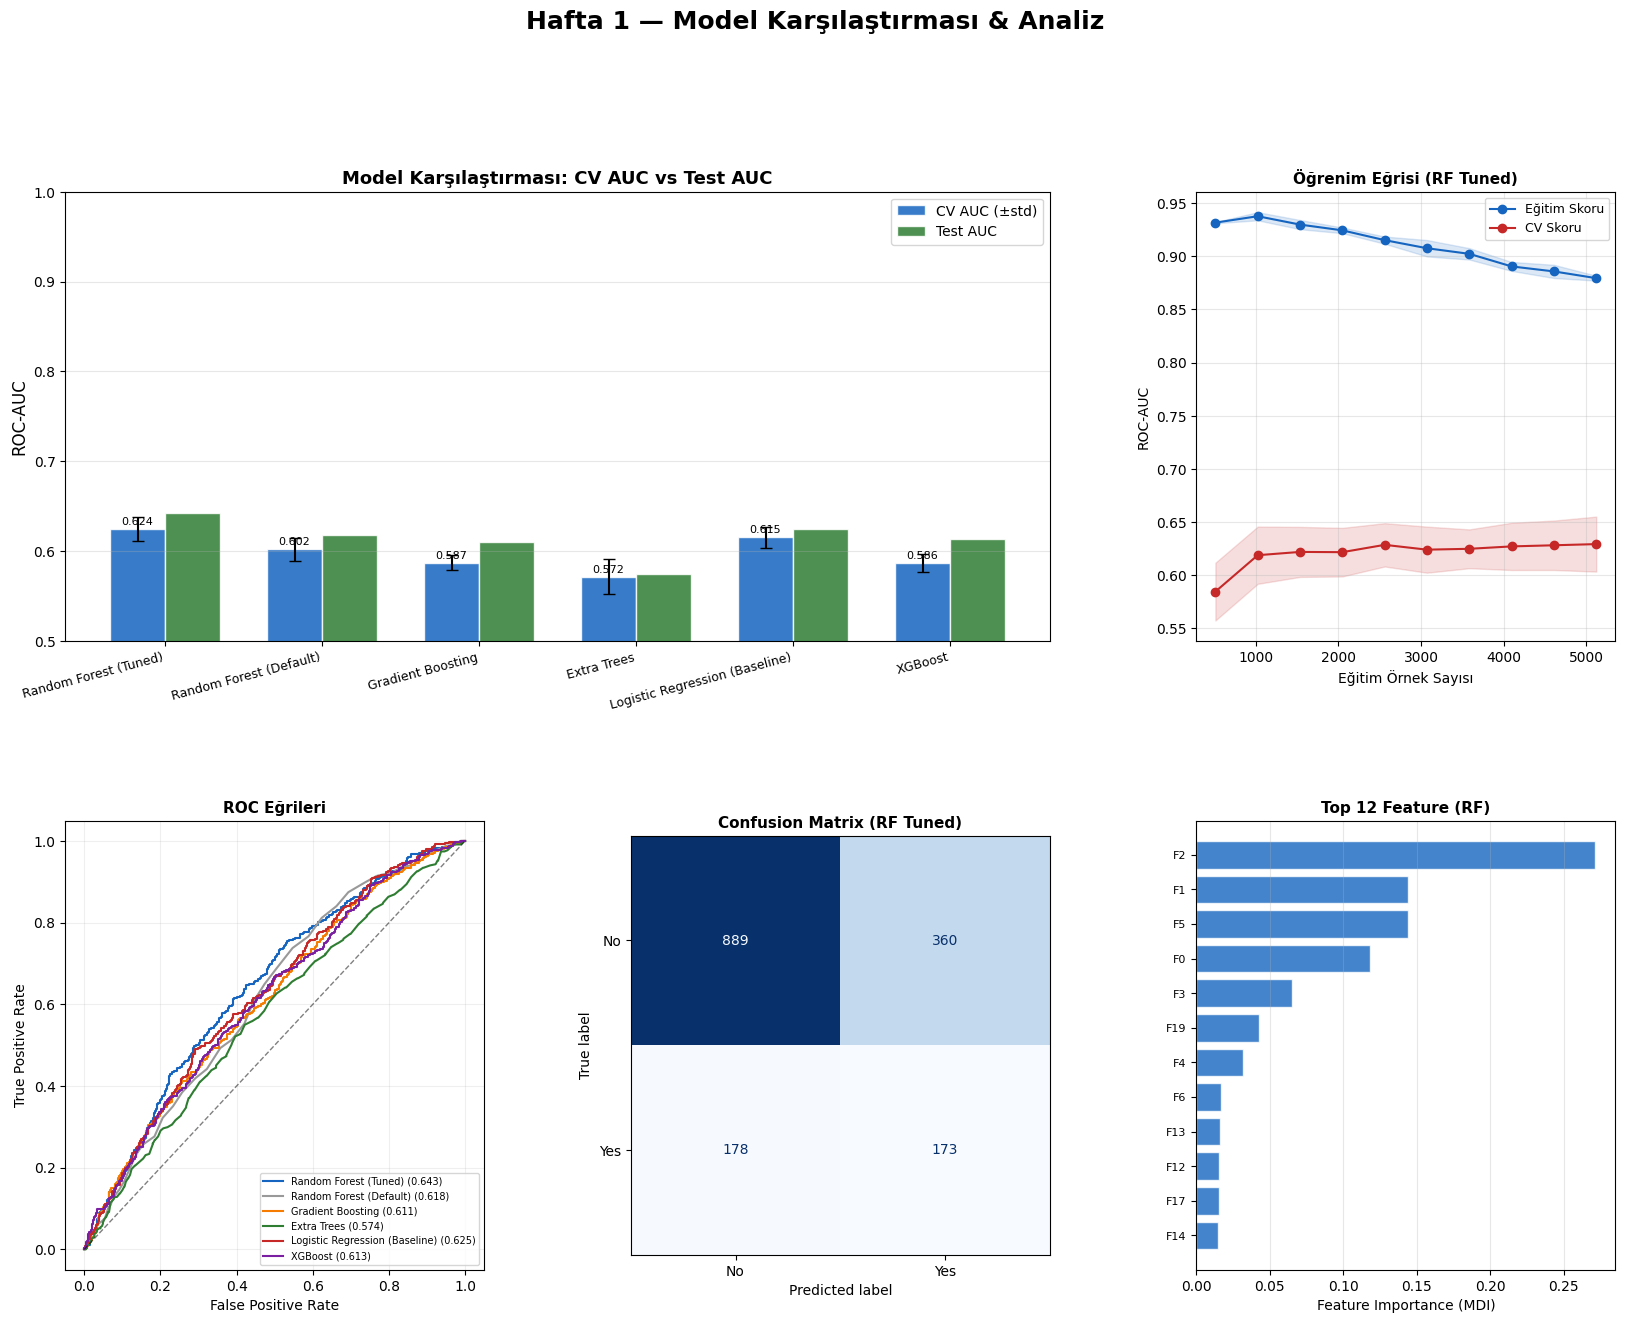

✅ Grafik kaydedildi: 04_model_comparison.png


In [11]:
# ─────────────────────────────────────────────────────────────
# 7. GÖRSELLEŞTİRME
# ─────────────────────────────────────────────────────────────
print("🎨 Görselleştirmeler hazırlanıyor...")

fig = plt.figure(figsize=(20, 14))
fig.suptitle("Hafta 1 — Model Karşılaştırması & Analiz", fontsize=18, fontweight="bold", y=1.01)
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# ── 7a. Karşılaştırma Bar Chart ──────────────────────────────
ax1 = fig.add_subplot(gs[0, :2])
names_clean = [n.replace("\n", " ") for n in results.keys()]
cv_means = [v["CV AUC Mean"] for v in results.values()]
cv_stds  = [v["CV AUC Std"] for v in results.values()]
test_aucs = [v["Test AUC"] for v in results.values()]

x = np.arange(len(names_clean))
w = 0.35
bars1 = ax1.bar(x - w/2, cv_means, w, yerr=cv_stds, capsize=4,
                label="CV AUC (±std)", color="#1565C0", alpha=0.85, edgecolor="white")
bars2 = ax1.bar(x + w/2, test_aucs, w,
                label="Test AUC", color="#2E7D32", alpha=0.85, edgecolor="white")
ax1.set_ylabel("ROC-AUC", fontsize=12)
ax1.set_title("Model Karşılaştırması: CV AUC vs Test AUC", fontsize=13, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(names_clean, rotation=15, ha="right", fontsize=9)
ax1.legend(fontsize=10)
ax1.set_ylim(0.5, 1.0)
ax1.grid(axis="y", alpha=0.3)
for bar in bars1:
    ax1.annotate(f"{bar.get_height():.3f}", xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 xytext=(0, 3), textcoords="offset points", ha="center", fontsize=8)

# ── 7b. Öğrenim Eğrisi ───────────────────────────────────────
ax2 = fig.add_subplot(gs[0, 2])
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)
ax2.plot(train_sizes, train_mean, "o-", color="#1565C0", label="Eğitim Skoru")
ax2.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color="#1565C0")
ax2.plot(train_sizes, val_mean, "o-", color="#C62828", label="CV Skoru")
ax2.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15, color="#C62828")
ax2.set_xlabel("Eğitim Örnek Sayısı")
ax2.set_ylabel("ROC-AUC")
ax2.set_title("Öğrenim Eğrisi (RF Tuned)", fontsize=11, fontweight="bold")
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)

# ── 7c. ROC Eğrileri ─────────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 0])
colors = ["#1565C0", "#999999", "#F57C00", "#2E7D32", "#C62828", "#7B1FA2"]
for i, (name, res) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, res["y_proba"])
    ax3.plot(fpr, tpr, color=colors[i % len(colors)],
             label=f"{name.replace(chr(10), ' ')} ({res['Test AUC']:.3f})", lw=1.5)
ax3.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.5)
ax3.set_xlabel("False Positive Rate")
ax3.set_ylabel("True Positive Rate")
ax3.set_title("ROC Eğrileri", fontsize=11, fontweight="bold")
ax3.legend(fontsize=7, loc="lower right")
ax3.grid(alpha=0.2)

# ── 7d. Confusion Matrix (Best RF) ───────────────────────────
ax4 = fig.add_subplot(gs[1, 1])
y_pred_best = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(ax=ax4, cmap="Blues", colorbar=False)
ax4.set_title("Confusion Matrix (RF Tuned)", fontsize=11, fontweight="bold")

# ── 7e. Feature Importance ───────────────────────────────────
ax5 = fig.add_subplot(gs[1, 2])
rf_model = best_rf.named_steps["classifier"]
importances = rf_model.feature_importances_
try:
    feat_names = best_rf.named_steps["preprocessor"].get_feature_names_out()
except Exception:
    feat_names = [f"F{i}" for i in range(len(importances))]
feat_names = [str(f) for f in feat_names]
top_n = 12
idx = np.argsort(importances)[-top_n:]
ax5.barh(range(top_n), importances[idx], color="#1565C0", alpha=0.8, edgecolor="white")
ax5.set_yticks(range(top_n))
ax5.set_yticklabels([feat_names[i] for i in idx], fontsize=8)
ax5.set_xlabel("Feature Importance (MDI)")
ax5.set_title(f"Top {top_n} Feature (RF)", fontsize=11, fontweight="bold")
ax5.grid(axis="x", alpha=0.3)

plt.savefig("04_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("✅ Grafik kaydedildi: 04_model_comparison.png")
plt.close()
